In this notebook I develop the functions to load chord annotations, to map them into major/minor classes and to compute one-hot ground truth encodings for NN learning

In [170]:
import madmom as mm
import numpy as np
import string
import matplotlib.pyplot as plt
%matplotlib inline

# One-hot ground truth

In [18]:
natural = zip(string.uppercase[:7], [0, 2, 3, 5, 7, 8, 10])
print natural

[('A', 0), ('B', 2), ('C', 3), ('D', 5), ('E', 7), ('F', 8), ('G', 10)]


In [22]:
sharp = map(lambda v: (v[0] + '#', (v[1] + 1) % 12), root_notes)
print sharp

[('A#', 1), ('B#', 3), ('C#', 4), ('D#', 6), ('E#', 8), ('F#', 9), ('G#', 11)]


In [23]:
flat = map(lambda v: (v[0] + 'b', (v[1] - 1) % 12), root_notes)
print flat

[('Ab', 11), ('Bb', 1), ('Cb', 2), ('Db', 4), ('Eb', 6), ('Fb', 7), ('Gb', 9)]


In [32]:
root_note_map = dict(natural + sharp + flat + [('N', 12)])

In [102]:
ann = np.loadtxt('beatles_07_Revolver_08_Good_Day_Sunshine.chords', dtype=str)

In [103]:
chords = ann[:, -1]

In [104]:
chord_root_notes = [c.split(':')[0] for c in chords]

In [105]:
chord_root_note_ids = np.array([root_note_map[crn] for crn in chord_root_notes])

In [106]:
chord_type = [c.split(':')[1] if ':' in c else '' for c in chords]

In [107]:
chord_type_shift = np.array(
    map(lambda x: 13 if 'min' in x or 'sus2' in x else 0, chord_type)
)

In [108]:
chord_class_id = chord_root_note_ids + chord_type_shift

In [109]:
n_chords = len(chord_class_id)

In [124]:
gt_one_hot = np.zeros((n_chords, 13 + 12), dtype=np.int)

In [125]:
gt_one_hot[np.arange(n_chords), chord_class_id] = 1

In [126]:
(gt_one_hot.argmax(axis=1) == chord_class_id).all()

True

# Timestamps

In [113]:
times = ann[:, :-1].astype(float)

In [122]:
if times.shape[1] == 1:
    end_times = np.vstack((times[1:], [np.inf]))
    times = np.hstack((times, end_times))

# Bringing it together

In [134]:
gt = np.empty((n_chords,), 
              dtype=[('start', np.float),
                     ('end', np.float),
                     ('one-hot', np.int, (gt_one_hot.shape[1]))])

In [135]:
gt['start'] = times[:, 0]
gt['end'] = times[:, 1]
gt['one-hot'] = gt_one_hot

In [137]:
gt[0]

(0.0, 0.4021, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Creating GT for spectra

In [140]:
spec = mm.audio.spectrogram.LogarithmicFilteredSpectrogram(
    'beatles_07_Revolver_08_Good_Day_Sunshine.flac',
    fps=50)

In [145]:
frame_times = np.arange(spec.num_frames) * (1. / spec.frames.fps)
print frame_times[:10]

[ 0.    0.02  0.04  0.06  0.08  0.1   0.12  0.14  0.16  0.18]


In [157]:
gt_per_frame = ((gt['start'] <= frame_times[:, np.newaxis]) &
                (frame_times[:, np.newaxis] < gt['end']))

In [184]:
(gt_per_frame.sum(1) == 1).all()  # each frame has exactly one ground truth

True

In [165]:
gt_per_frame.shape

(6489, 59)

In [182]:
one_hot_per_frame = gt['one-hot'][np.nonzero(gt_per_frame)[1]]

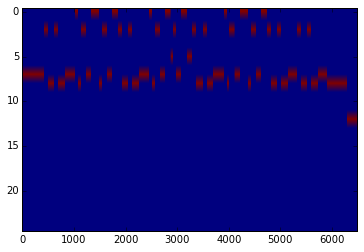

In [183]:
plt.imshow(one_hot_per_frame.T, aspect='auto')